## Madison, WI Incident Reports
#### Shane Kennedy

### Imports and Additional Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib, time, string, re
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt

In [2]:
df = pd.read_csv("incidents_cleaned.csv") 

df["coords"] = df["coords"].apply(wkt.loads) # converts str to shapely obj
df["date"] = pd.to_datetime(df["date"])

df["date"] = pd.to_datetime(df["date"])

geodf = gpd.GeoDataFrame(df, geometry="coords", crs="epsg:3857")

### Data Exploration

First, let's take a quick look at our dataset! 

In [3]:
df.head()

,date,incident,address,officer,casenumber,updated,link,description,officer_type,release_time,len_desc,coords,violent,univ,drug,gang
0,2022-12-21,Traffic Incident,"E. Johnson St.:Madison, WI",PIO Stephanie Fryer,2022-515112,NaN,https://www.cityofmadison.com/police/newsroom/...,The Madison Police Department responded to a t...,Public Information Officer,12:42 AM,455,POINT (-89.367 43.091),0,0,0,0
1,2022-12-21,Battery,"1800 Aberg Ave.:Madison, WI",PIO Stephanie Fryer,2022-515237,NaN,https://www.cityofmadison.com/police/newsroom/...,Madison police were called after a fight betwe...,Public Information Officer,12:36 AM,303,POINT (-89.361 43.114),1,0,0,0
2,2022-12-21,Traffic Incident,"Mineral Point Rd.:Madison, WI",PIO Stephanie Fryer,2022-515427,NaN,https://www.cityofmadison.com/police/newsroom/...,One person was injured during a two-car crash ...,Public Information Officer,12:31 AM,452,POINT (-89.517 43.061),0,0,0,0
3,2022-12-21,Check Person,"S. Stoughton Rd.:Madison, WI",PIO Stephanie Fryer,2022-515382,NaN,https://www.cityofmadison.com/police/newsroom/...,Officers were sent to help a woman found lying...,Public Information Officer,12:25 AM,331,POINT (-89.316 43.097),0,0,0,0
4,2022-12-20,Intoxicated/Impaired Driver,"Pflaum rd.:Madison, WI",PIO Stephanie Fryer,2022-513904,NaN,https://www.cityofmadison.com/police/newsroom/...,A woman was arrested for third-offense OWI fol...,Public Information Officer,8:08 AM,681,POINT (-89.306 43.062),0,0,0,0


Here we are looking at all columns of our dataset. We added the "officer_type", "release_time", "len_desc", "coords", "violent", "univ", "drug", and "gang" variables with our data_cleaning.py file. The remaining variables were pulled using our report_scraper.py file. 

In [4]:
df.columns

Index(['date', 'incident', 'address', 'officer', 'casenumber', 'updated',
       'link', 'description', 'officer_type', 'release_time', 'len_desc',
       'coords', 'violent', 'univ', 'drug', 'gang'],
      dtype='object')

Here is a brief description of all of the incidents:
- date: The date that the Incident Report (IR) was released.
- incident: The type of incident.
- address: The address where the incident occured.
- officer: The officer that wrote the report.
- casenumber: Self-explanatory.
- updated: A date if the IR was ever updated with additional info, missing (NaN) if not.
- link: A link to the IR.
- description: The description of the incident.
- officer_type: The title of the officer that wrote the IR.
- release_time: The time that the IR was released.
- len_desc: The length of the description.
- coords: The location of the incident in the form of a Shapely point. 
- violent: Whether the crime or incident was violent in nature, according (loosely) to the FBI UCR.(1 if violent, 0 if not)
- univ: Whether the description of the incident contained the word "university". (1 if yes, 0 if not)
- drug: Whether the description of the incident contained any common drugs. (1 if yes, 0 if not)
- gang: Whether the description of the incident contained the word "gang/s" (1 if yes, 0 if not)

As we can see, due to the nature of our data, most of the features are qualitative. In the data cleaning process, I added some numerical features that I thought would be interesting to explore. The 'drug' variable may not be completely accurate, as street names and other less-direct references were not included in the list used for text-processing. Because most of our features are qualitative, it may be more challenging to run any meaningful ML models, but we can still explore the data quite a bit with visualization and general EDA techniques.

Here we are checking the values of some random entries using the sample() function, just to make sure that all of our data still looks reasonable.

In [5]:
df.sample(3)

,date,incident,address,officer,casenumber,updated,link,description,officer_type,release_time,len_desc,coords,violent,univ,drug,gang
1611,2020-07-15,Weapons Violation,"Watts Rd.:Madison, WI",PIO Joel Despain,2020-257056,07/16/2020,https://www.cityofmadison.com/police/newsroom/...,Many have called 911 in the past hour rep...,Public Information Officer,1:24 PM,674,POINT (-89.514 43.051),0,0,0,0
176,2022-08-31,Weapons Violation,"1675 Highland Ave.:Madison, WI",P.O. Hunter Lisko,2022-353593,NaN,https://www.cityofmadison.com/police/newsroom/...,"On Wednesday morning, Madison Police officers ...",Police Officer,4:16 PM,538,POINT (-89.433 43.077),0,0,0,0
9,2022-12-19,Intoxicated/Impaired Driver,"2400 E. Springs Dr.:Madison, WI",PIO Stephanie Fryer,2022-509563,NaN,https://www.cityofmadison.com/police/newsroom/...,A K-9 team helped track down a man who was spo...,Public Information Officer,1:11 PM,1227,POINT (-89.295 43.130),0,0,0,0


Below we are exploring all of the different types of incidents reported. There are 39 of them! 

In [6]:
df["incident"].unique()

array(['Traffic Incident', 'Battery', 'Check Person',
       'Intoxicated/Impaired Driver', 'Information',
       'Non-Residential Burglary', 'Overdose', 'Disturbance',
       'Unwanted Person', 'Traffic incident/Road Rage',
       'Attempted Homicide', 'Damaged Property', 'Weapons Violation',
       'Theft', 'Arrested Person', 'Residential Burglary',
       'Murder/Homicide', 'Missing Adult', 'Robbery', 'Fraud',
       'Suspicious Person', 'Sexual Assault', 'Drug Investigation',
       'Missing Juvenile', 'Domestic/Family Trouble',
       'Fight (In Progress)', 'Miscellaneous Sex Offense',
       'Suspicious Vehicle', 'Trespassing Complaint', 'Special Event',
       'Death Investigation', 'Threats', 'Attempt to Locate Person',
       'Animal Complaint - Bite', 'Animal Complaint - Disturbance',
       'Exposure', 'Injured Person', 'Neighbor Trouble', 'Child Abuse'],
      dtype=object)

In [7]:
len(df["incident"].unique())

39

Luckily, there is no missing data besides for the updated column, which was expected. It appears our scraper did a pretty good job collecting everything! 

In [8]:
df.isnull().sum() 

date               0
incident           0
address            0
officer            0
casenumber         0
updated         1887
link               0
description        0
officer_type       0
release_time       0
len_desc           0
coords             0
violent            0
univ               0
drug               0
gang               0
dtype: int64

Below we are looking at some summary statistics of the numerical variables in the dataset.
Notable findings from this include:
- Approximately 28% of crimes/incidents are violent in nature.
- Approximately 1% of IRs mention "university" in any way.
- Approximately 8% of IRs mention common drugs. 
- Approximately 0.8% of IRs mention "gang" or "gangs". 

In [9]:
df.describe()

,len_desc,violent,univ,drug,gang
count,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000
mean,662.824841,0.277525,0.010919,0.076433,0.007734
std,401.279255,0.447880,0.103946,0.265750,0.087624
min,128.000000,0.000000,0.000000,0.000000,0.000000
25%,445.500000,0.000000,0.000000,0.000000,0.000000
50%,578.000000,0.000000,0.000000,0.000000,0.000000
75%,788.000000,1.000000,0.000000,0.000000,0.000000
max,8249.000000,1.000000,1.000000,1.000000,1.000000


Here we are checking out who wrote most of the reports. Unsurprisingly "PIO"s write the majority of the incident reports. PIO stands for Public Information Officer.

In [10]:
df["officer"].value_counts()

PIO Joel Despain       706
PIO Stephanie Fryer    309
PIO Tyler Grigg        139
Lt. Kipp Hartman       109
Sgt. Ryan Gibson       107
                      ... 
P.O. Ryan Gibson         1
Ronald Webster           1
Lt. Kimberly Alan        1
Stephanie Fryer          1
Lt. Tracie Jokala        1
Name: officer, Length: 86, dtype: int64

Let's see some of the addresses where most incidents occur. 

- The malls (West and East Towne)
- East Washington Avenue
- West Gilman Street (especially near the intersection with State St.)
- Police Departments (211 S. Caroll St, 1710 McKenna Blvd) Likely for informational or ambiguous incidents.
- The Walgreens on Raymond Road (5702 Raymond Rd.)
- South Stoughton Road
- Mineral Point Road
- South Whitney Way

Unsurprisingly, most of the incidents are at the busiest places and roads in the city. It would be interesting to compare this data with total foot traffic or visits to see if any location is highly unusual in terms of incident involvement.

In [11]:
df["address"].value_counts()[:15]

Madison:Madison, WI               11
West Towne Mall:Madison, WI       10
E. Washington Ave.:Madison, WI     9
400 W. Gilman St.:Madison, WI      8
E Washington Ave:Madison, WI       8
211 S Carroll:Madison, WI          7
S. Stoughton Rd.:Madison, WI       7
200 W. Gilman St.:Madison, WI      7
East Towne Mall:Madison, WI        7
211 S Carroll St:Madison, WI       7
Mineral Point Rd.:Madison, WI      6
1710 McKenna Blvd.:Madison, WI     5
S. Whitney Way:Madison, WI         5
5702 Raymond Rd.:Madison, WI       5
211 S. Carroll St.:Madison, WI     5
Name: address, dtype: int64

Let's see our oldest datapoint: April 2nd, 2008! 
Our newest datapoint is just the date of the last time that we ran our scraper. 

In [12]:
df["date"].min() 

Timestamp('2008-04-02 00:00:00')

In [13]:
df["date"].max()

Timestamp('2022-12-21 00:00:00')

### Data Visualization

This is a barplot showing the most common incident types in Madison.

Text(0.5, 0, 'Number of Occurences')

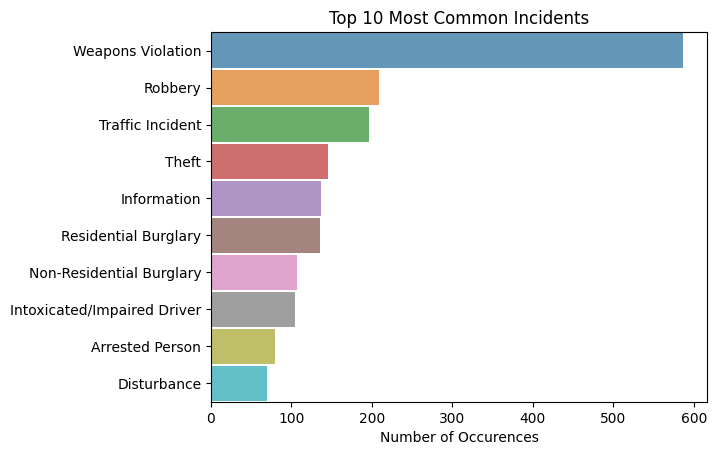

In [14]:
incident_counts = df["incident"].value_counts()[:10] 
fig, ax = plt.subplots()
sns.barplot(y=incident_counts.index, x=incident_counts.values, 
            width=0.95, alpha=0.75, orient="h", ax=ax)
plt.title("Top 10 Most Common Incidents")
plt.xlabel("Number of Occurences")

The following plot demonstrates the change in incident frequency over time. Data in 2019 and before was incomplete, so we dropped it from the data for this plot, and any following plots involving time or date. There appears to be a massive spike in incidents right around when the COVID-19 pandemic began, and a steady decline thereafter. It is also interesting to note that crime/IRs appears to spike each late summer/early fall, which is consistent with the general understanding of crime statistics. 

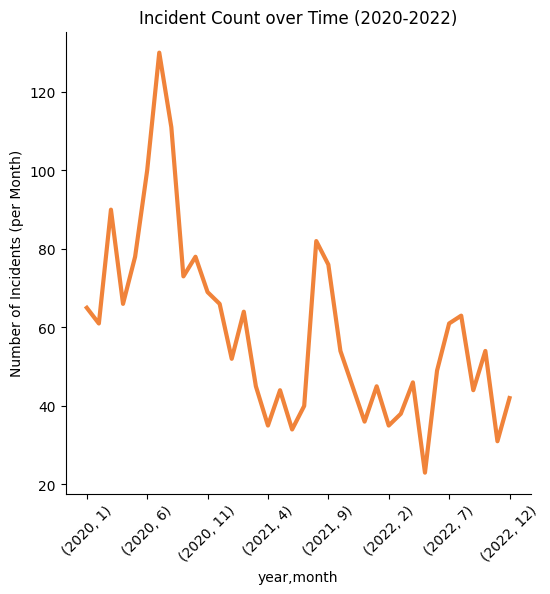

In [15]:
df_recent = df[df["date"] > "2019-12-31"] 
month_freq = df_recent['date'].groupby([df_recent.date.dt.year.rename("year"), 
                                  df_recent.date.dt.month.rename("month")]).agg('count')

ax = month_freq.plot(linewidth=3, c="xkcd:dusty orange", figsize=(6,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set(ylabel = "Number of Incidents (per Month)",
      title = "Incident Count over Time (2020-2022)")

ax.tick_params(axis='x', labelrotation=45)

Here we use geopandas to plot the geographic location of each of the incidents. The grey boundary is the city limit, as defined by the City of Madison. It appears that many more incidents occur on the Isthmus than anywhere else, especially south of the Capitol Building. There also appears to be some incident congregation on the West Side, and the upper East side. In general it seems as if incidents on the East Side are more spread out and consistent, whereas on the West Side incidents may be clustered more closely together.

Text(0.5, -0.01, 'All Incident Locations in Madison, WI')

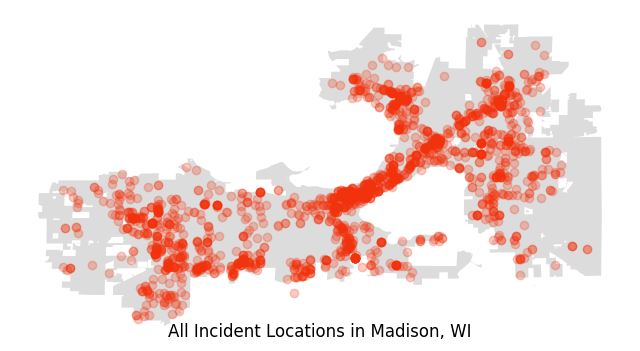

In [16]:
madison_shape = gpd.read_file("City_Limit.shp")
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()
geodf.plot(ax=ax,color="xkcd:vermillion", alpha=0.25)
ax.set_title("All Incident Locations in Madison, WI", y=-0.01)

This is the same map as above, but now we distinguish between "violent" and "nonviolent" crime types. In the initial plot above, it may have appeared that the Isthmus was the most dangerous part of Madison, but this plot may prove otherwise. It looks like mostly nonviolent crimes occur near the Captiol, whereas a large congregation of violent crimes occur on the West Side. 

Text(0.5, -0.01, 'Violent Crimes in Madison, WI')

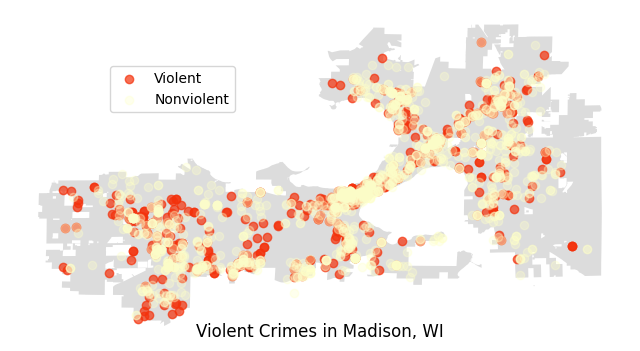

In [17]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))

violent_incidents = geodf[geodf["violent"]==1]
nonviolent_incidents = geodf[geodf["violent"]==0]
ax.set_axis_off()

violent_incidents.plot(color="xkcd:vermillion", alpha=0.70, ax=ax)
nonviolent_incidents.plot(color="xkcd:ecru", alpha=0.33, ax=ax)

ax.legend(labels=["Violent", "Nonviolent"], loc="upper left", bbox_to_anchor=(0.15, 0.85))
ax.set_title("Violent Crimes in Madison, WI", y=-0.01)

Earlier, we saw some of the most common incident types in Madison. Here we plot them geographically to discern if any one crime occurs in a specific area. Most of these crime types appear pretty evenly distributed. It does seem like more residential burglaries occur on the West Side, and that more Weapons Violations occur on the East Side. 

Text(0.5, -0.01, 'Incidents by type in Madison, WI')

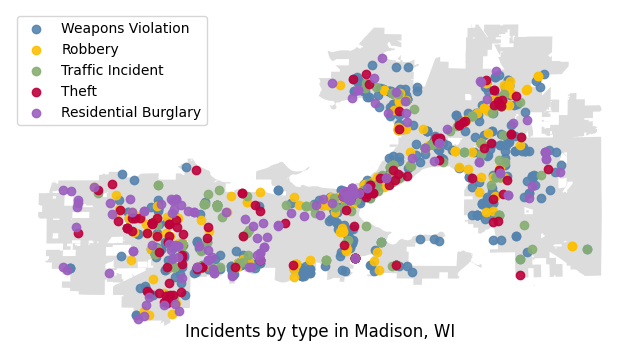

In [18]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()

wv_df = geodf[geodf["incident"] == "Weapons Violation"]
rob_df = geodf[geodf["incident"] == "Robbery"]
traf_df = geodf[geodf["incident"] == "Traffic Incident"]
thft_df = geodf[geodf["incident"] == "Theft"]
resb_df = geodf[geodf["incident"] == "Residential Burglary"]

wv_df.plot(ax=ax, c = "xkcd:off blue", alpha = 0.9)
rob_df.plot(ax=ax, c = "xkcd:marigold", alpha = 0.9)
traf_df.plot(ax=ax, c = "xkcd:sage", alpha = 0.9)
thft_df.plot(ax=ax, c = "xkcd:rose red", alpha = 0.9)
resb_df.plot(ax=ax, c = "xkcd:amethyst", alpha = 0.9)
ax.legend(labels=["Weapons Violation", "Robbery", "Traffic Incident", "Theft", "Residential Burglary"])
ax.set_title("Incidents by type in Madison, WI", y=-0.01)

Homicide is a very serious incident, so let's visualize where they occur. Thankfully, murder is much less common in comparison to other crimes. However, there seems to be no clear grouping of where they occur within City Limits. It looks like they may be more common in the Fitchburg and Campus areas, and also near the Northern part of Lake Mendota. 

Text(0.5, -0.01, 'Murders in Madison, WI')

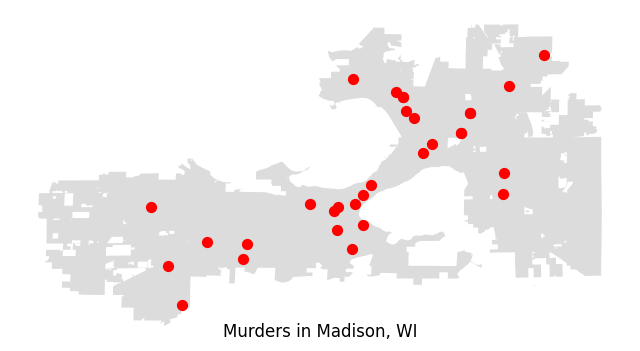

In [19]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()

murder_df = geodf[geodf["incident"] == "Murder/Homicide"]

murder_df.plot(ax=ax, markersize=50, color = "r")
ax.set_title("Murders in Madison, WI", y=-0.01)

It would also be interesting to see where gang related incidents occur in Madison. The South Side and the Isthmus of the City appears to have much more gang involvement.

Text(0.5, -0.01, 'Gang-Related Incidents in Madison, WI')

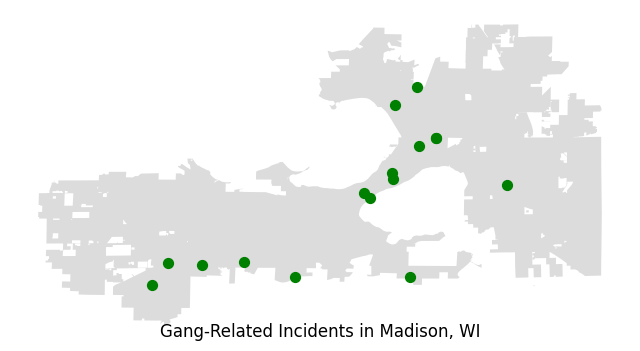

In [20]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()

murder_df = geodf[geodf["gang"] == 1]

murder_df.plot(ax=ax, markersize=50, color = "green")
ax.set_title("Gang-Related Incidents in Madison, WI", y=-0.01)

Here are IRs where the description contains "university". Unsurprisingly, most incidents are near UW-Madison, and it looks like one incident is at the Goodman-South MATC Campus, one at the MATC West campus, and one near the main/Truax MATC campus.

Text(0.5, -0.01, 'University-related Incidents in Madison, WI')

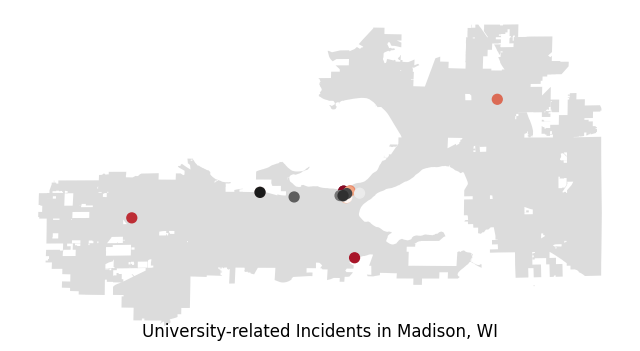

In [21]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()

murder_df = geodf[geodf["univ"] == 1]

murder_df.plot(ax=ax, markersize=50, cmap="RdGy")
ax.set_title("University-related Incidents in Madison, WI", y=-0.01)

Finally, let's see where the drug-related incidents occur. They seem to be consistent with total crime/incidents. 

Text(0.5, -0.01, 'Drug-related Incidents in Madison, WI')

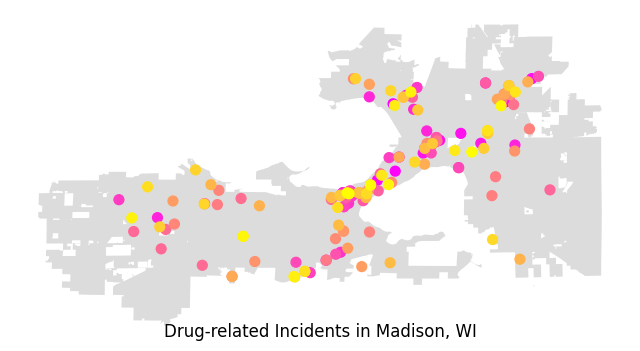

In [22]:
ax = madison_shape.plot(color="gainsboro", figsize=(8,8))
ax.set_axis_off()

murder_df = geodf[geodf["drug"] == 1]

murder_df.plot(ax=ax, markersize=50, cmap = "spring")
ax.set_title("Drug-related Incidents in Madison, WI", y=-0.01)

Earlier we saw monthly number of Incident reports over time, but it would be interesting to split it up by incident, which is what we do here. Some incidents have more interesting plots than others, such as Missing Adults shooting up recently, and the overall decline in Weapons Violations since the beginning of the pandemic. Take a look and see if you can see any interesting results! 

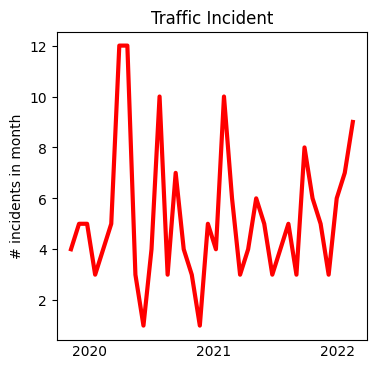

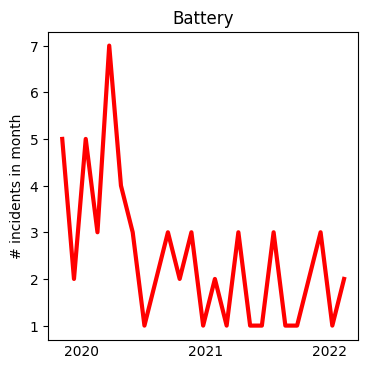

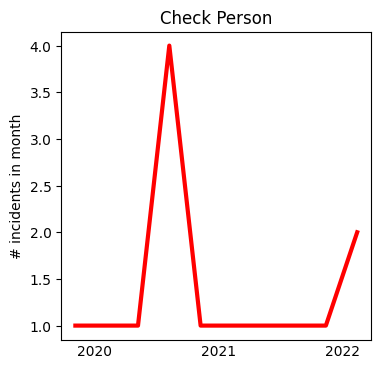

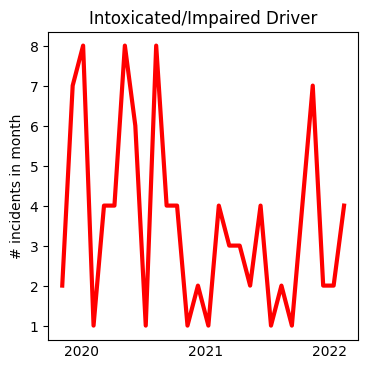

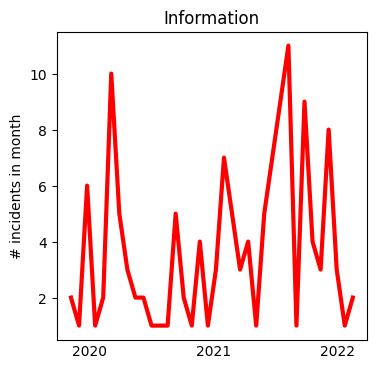

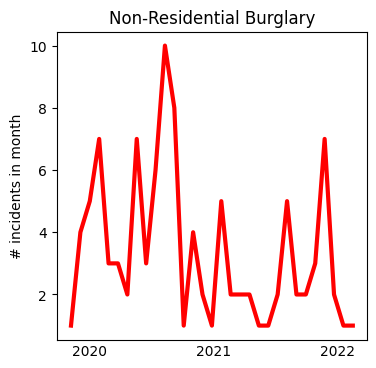

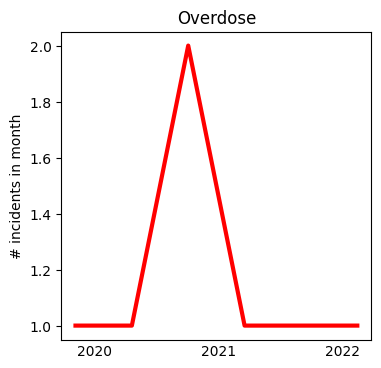

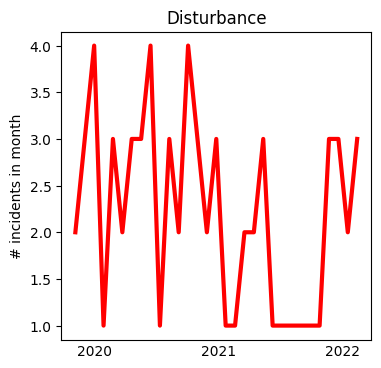

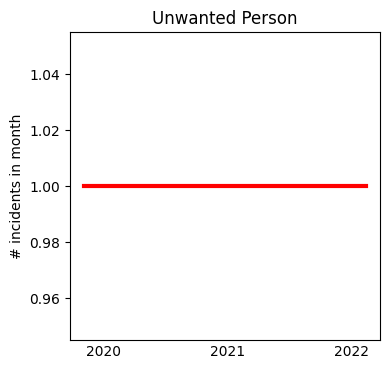

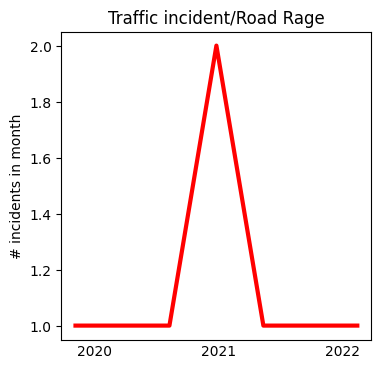

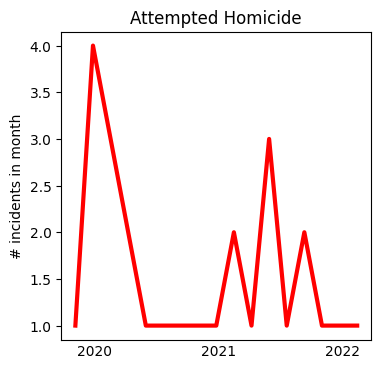

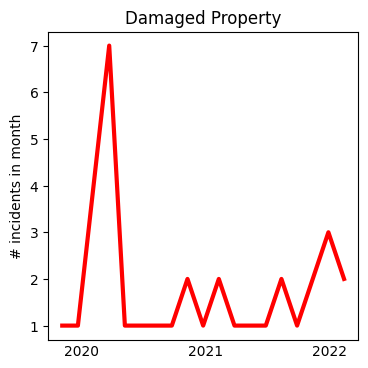

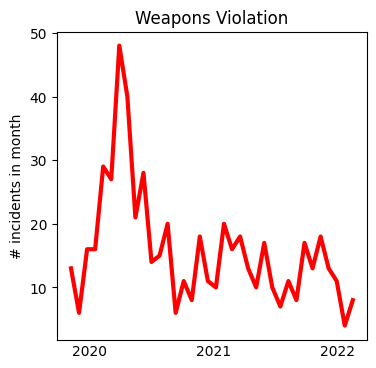

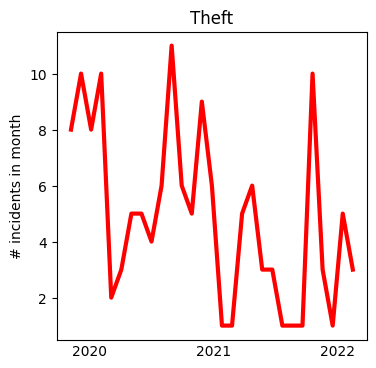

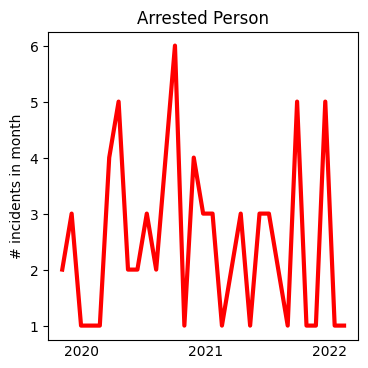

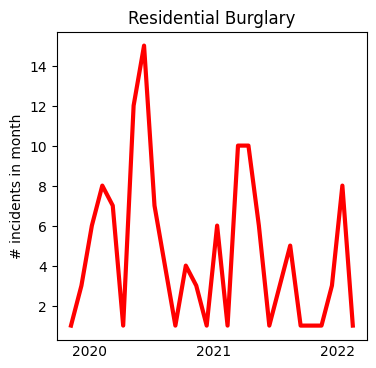

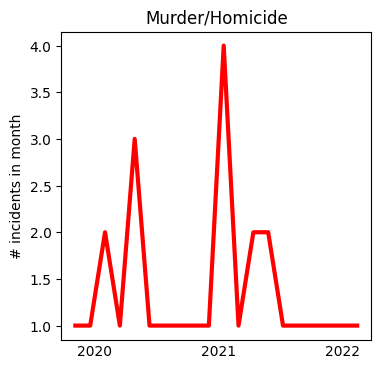

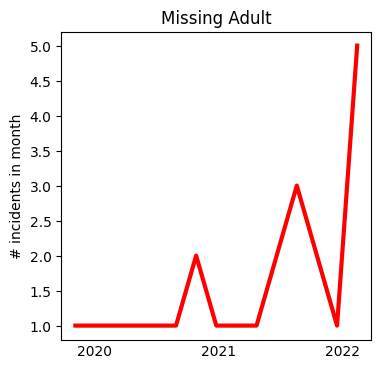

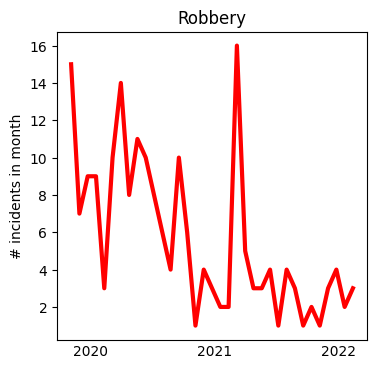

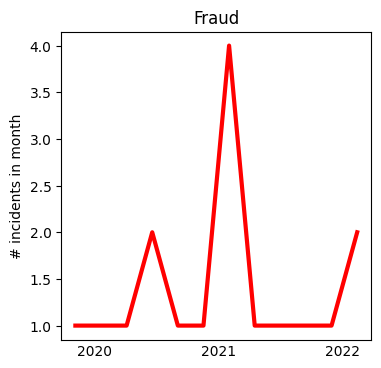

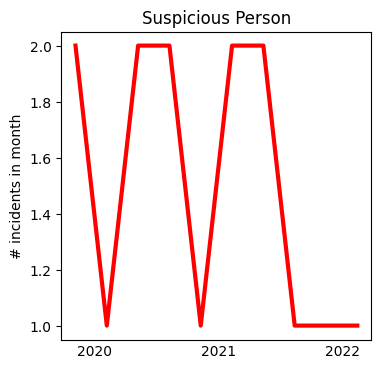

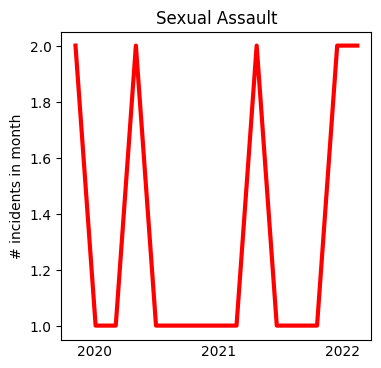

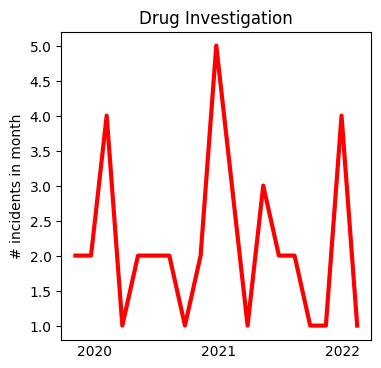

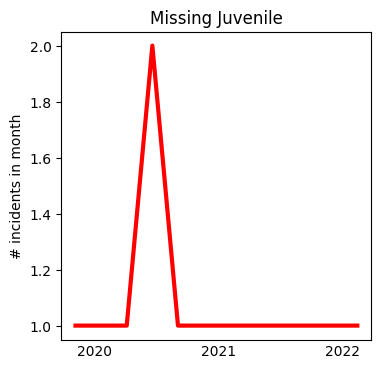

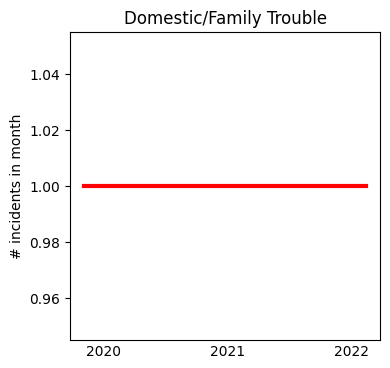

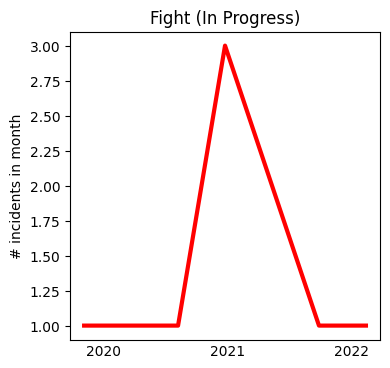

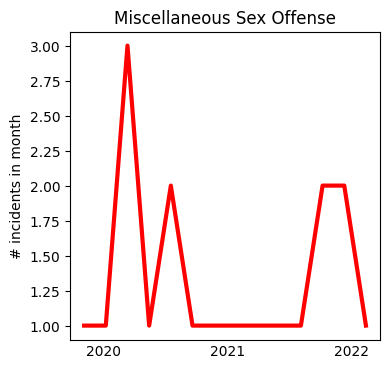

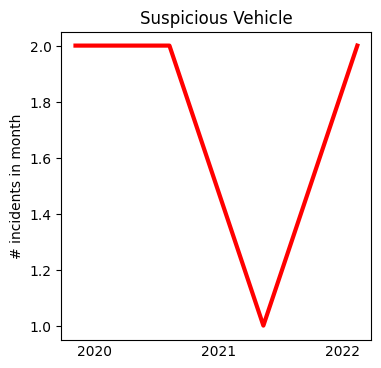

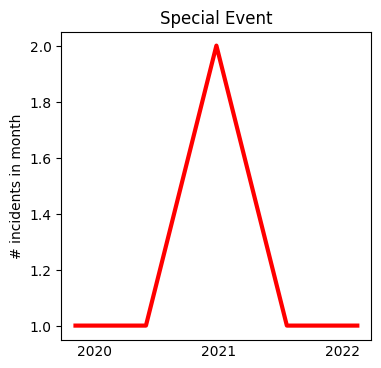

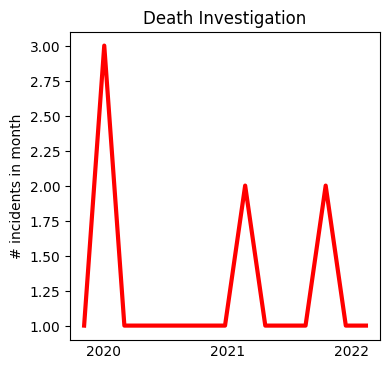

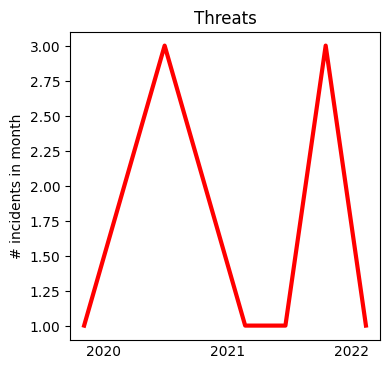

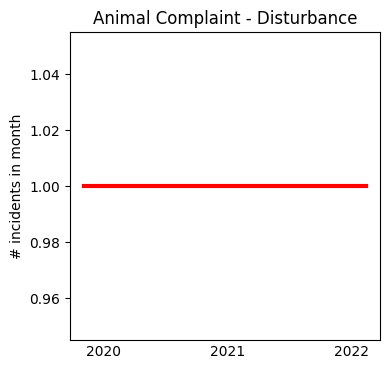

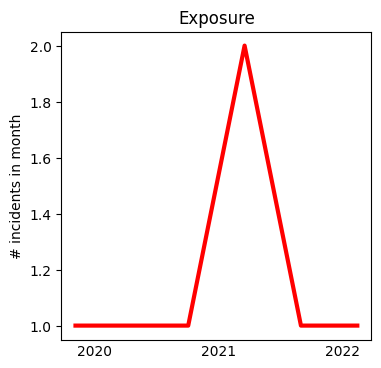

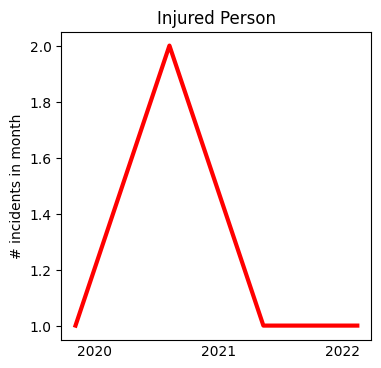

In [23]:
inc_dict_list = []
for inc in df_recent["incident"].unique():
    inc_dict = {}
    inc_df = df_recent[df_recent["incident"] == inc]
    month_freq_inc = inc_df["date"].groupby([inc_df.date.dt.year.rename("year"),
                                           inc_df.date.dt.month.rename("month")]).agg("count")
    inc_dict[inc] = month_freq_inc
    inc_dict_list.append(inc_dict) 

for incident_dict in inc_dict_list:
    for incident in incident_dict:
        if len(incident_dict[incident]) < 2: # Not plotting if 1 datapoint
            continue
        fig, ax = plt.subplots()
        incident_dict[incident].plot(figsize=(4,4), linewidth=3, c="r")
        plt.title(incident)
        plt.ylabel("# incidents in month")
        plt.xticks([])
        # pandas groupby makes the x-axis visually unappealing so I added x-axis labels manually
        plt.text(0.05, -0.05, "2020", transform=ax.transAxes) 
        plt.text(0.45, -0.05, "2021", transform=ax.transAxes)
        plt.text(0.85, -0.05, "2022", transform=ax.transAxes)
        ax.get_xaxis().set_visible(False)
        plt.show()
        plt.close()

### Summary

Through this exploration of the Incident Report data, we were able to visualize many key features, and gain some insights on different types of crime in Madison. We gathered lots of data, and were able to plot it in an interesting way. The most notable findings in my opinion, include seeing the distribution of crime geographically, and how different incidents frequency changed over time. There are various potential applications for this data and analysis, such as monitoring the change in crime rate in different areas, or even simply pushing important incident information to the public.

There is definitely much more analysis that could be done using this dataset, so let me know if you have any ideas!
- snkennedy2 (at) wisc [dot] edu

#### Future Questions and Considerations:
- It would be super interesting to tie in datasets relating to other major facets of society such as economics/poverty rate, family/divorce, governmental institutions such as hospitals, schools, etc. to see if there is any potential correlation or effect on incidents and crime.
- It would also be interesting to compare this data to other cities. Madison is known as being much safer than other similarly sized metropolitan areas, so demonstrating that visually or through data comparison would be cool. 
- Integrating a dashboard to show recent incidents, locations, etc. could be beneficial to both the public and to the city.
